In [48]:
import json
import re

import pandas as pd
import numpy as np
from tqdm import tqdm

import cfbd
from cfbd.rest import ApiException

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open("../config.json") as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)["CFBD_API_KEY"]
    )

In [140]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

# load games data for years 2000 to 2024
all_games = []
with cfbd.ApiClient(configuration) as api_client:
    api_instance = cfbd.GamesApi(api_client)
    for year in tqdm(range(2000, 2024 + 1), desc="Loading games data"):
        games = api_instance.get_games(year=year)
        df_games = pd.DataFrame([game.to_dict() for game in games])
        df_games.columns = convert_to_snake_case(df_games.columns)
        game_cols = ['id','season','week','season_type','completed','neutral_site',
                    #  'home_id','home_team','home_conference','home_points','home_classification',
                    #  'away_id','away_team','away_conference','away_points','away_classification']
                    'home_id','home_team','home_points',
                    'away_id','away_team','away_points']
        df_games = df_games[game_cols]
        df_games['season_type'] = df_games['season_type'].apply(lambda x: x.value)
        # def get_division(division):
        #     try:
        #         return division.value
        #     except AttributeError:
        #         return np.nan
        # df_games['away_division'] = df_games['away_classification'].apply(get_division)
        # df_games['home_division'] = df_games['home_classification'].apply(get_division)
        # df_games.drop(columns=['away_classification','home_classification'], inplace = True)
        all_games.append(df_games)

# concatenate all dataframes
df_games = pd.concat(all_games, ignore_index=True).query("completed == True").reset_index(drop=True)
df_games.head()

Loading games data: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


,id,season,week,season_type,completed,neutral_site,home_id,home_team,home_points,away_id,away_team,away_points
0,63068,2000,1,regular,True,False,52,Florida State,29.0,252,BYU,3.0
1,63071,2000,1,regular,True,False,2641,Texas Tech,24.0,167,New Mexico,3.0
2,63070,2000,1,regular,True,False,2348,Louisiana Tech,63.0,2400,Mississippi Valley State,10.0
3,63069,2000,1,regular,True,False,2306,Kansas State,27.0,2294,Iowa,7.0
4,63072,2000,1,regular,True,False,30,USC,29.0,213,Penn State,5.0


In [141]:
df_games.isna().sum()

id              0
season          0
week            0
season_type     0
completed       0
neutral_site    0
home_id         0
home_team       0
home_points     0
away_id         0
away_team       0
away_points     0
dtype: int64

In [142]:
all_teams = []
with cfbd.ApiClient(configuration) as api_client:
    api_instance = cfbd.TeamsApi(api_client)
    for year in tqdm(range(2000, 2024 + 1), desc="Loading team data"):    
        teams = api_instance.get_teams(year=year)
        df = pd.DataFrame([team.to_dict() for team in teams])
        df.columns = convert_to_snake_case(df.columns)
        df.insert(0, 'season', year)
        all_teams.append(df)

df_teams = pd.concat(all_teams, ignore_index=True)
df_teams.head()

Loading team data: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]


,season,id,school,mascot,abbreviation,alternate_names,conference,division,classification,color,alternate_color,logos,twitter,location
0,2000,2,Auburn,Tigers,AUB,"[AUB, Auburn]",SEC,West,fbs,#002b5c,#f26522,[http://a.espncdn.com/i/teamlogos/ncaa/500/2.p...,@AuburnFootball,"{'id': 3785, 'name': 'Jordan-Hare Stadium', 'c..."
1,2000,5,UAB,Blazers,UAB,"[Alabama-Birmingham, UAB, UAB]",Conference USA,None,fbs,#003b28,#ffc845,[http://a.espncdn.com/i/teamlogos/ncaa/500/5.p...,@UAB_FB,"{'id': 7221, 'name': 'Protective Stadium', 'ci..."
2,2000,8,Arkansas,Razorbacks,ARK,"[ARK, Arkansas]",SEC,West,fbs,#a41f35,#ffffff,[http://a.espncdn.com/i/teamlogos/ncaa/500/8.p...,@RazorbackFB,"{'id': 3887, 'name': 'Razorback Stadium', 'cit..."
3,2000,9,Arizona State,Sun Devils,ASU,"[ASU, Arizona St]",Pac-10,None,fbs,#8e0c3a,#ffc72c,[http://a.espncdn.com/i/teamlogos/ncaa/500/9.p...,@ASUFootball,"{'id': 3947, 'name': 'Mountain America Stadium..."
4,2000,12,Arizona,Wildcats,ARIZ,"[ARIZ, Arizona]",Pac-10,None,fbs,#0c234b,#ab0520,[http://a.espncdn.com/i/teamlogos/ncaa/500/12....,@ArizonaFBall,"{'id': 3619, 'name': 'Arizona Stadium', 'city'..."


In [143]:
team_cols = ['season','id','abbreviation','conference','classification','color','alternate_color','logos']

df_games = df_games.merge(
    df_teams[team_cols].rename(columns={c: 'home_' + c for c in team_cols}),
    left_on=['season','home_id'],
    right_on=['home_season','home_id'], 
).drop(columns=['home_season'])

df_games = df_games.merge(
    df_teams[team_cols].rename(columns={c: 'away_' + c for c in team_cols}),
    left_on=['season','away_id'],
    right_on=['away_season','away_id'],
).drop(columns=['away_season'])

In [144]:
id_cols = ['id','season','week','season_type','completed','neutral_site']
team_cols = [c for c in df_games.columns if c not in id_cols]
df_games = df_games[id_cols + sorted(team_cols)]
df_games.head()

,id,season,week,season_type,completed,neutral_site,away_abbreviation,away_alternate_color,away_classification,away_color,away_conference,away_id,away_logos,away_points,away_team,home_abbreviation,home_alternate_color,home_classification,home_color,home_conference,home_id,home_logos,home_points,home_team
0,63068,2000,1,regular,True,False,BYU,#ffffff,fbs,#003da5,Mountain West,252,[http://a.espncdn.com/i/teamlogos/ncaa/500/252...,3.0,BYU,FSU,#ceb888,fbs,#782f40,ACC,52,[http://a.espncdn.com/i/teamlogos/ncaa/500/52....,29.0,Florida State
1,63071,2000,1,regular,True,False,UNM,#a7a8aa,fbs,#BA0C2F,Mountain West,167,[http://a.espncdn.com/i/teamlogos/ncaa/500/167...,3.0,New Mexico,TTU,#000000,fbs,#CC0000,Big 12,2641,[http://a.espncdn.com/i/teamlogos/ncaa/500/264...,24.0,Texas Tech
2,63069,2000,1,regular,True,False,IOWA,#FFCD00,fbs,#000000,Big Ten,2294,[http://a.espncdn.com/i/teamlogos/ncaa/500/229...,7.0,Iowa,KSU,#e2e3e4,fbs,#3c0969,Big 12,2306,[http://a.espncdn.com/i/teamlogos/ncaa/500/230...,27.0,Kansas State
3,63072,2000,1,regular,True,False,PSU,#FFFFFF,fbs,#041E42,Big Ten,213,[http://a.espncdn.com/i/teamlogos/ncaa/500/213...,5.0,Penn State,USC,#ffcc00,fbs,#9e2237,Pac-10,30,[http://a.espncdn.com/i/teamlogos/ncaa/500/30....,29.0,USC
4,63075,2000,2,regular,True,False,WYO,#ffc425,fbs,#492f24,Mountain West,2751,[http://a.espncdn.com/i/teamlogos/ncaa/500/275...,21.0,Wyoming,AUB,#f26522,fbs,#002b5c,SEC,2,[http://a.espncdn.com/i/teamlogos/ncaa/500/2.p...,35.0,Auburn


In [145]:
df_games.isna().sum()

id                        0
season                    0
week                      0
season_type               0
completed                 0
neutral_site              0
away_abbreviation        24
away_alternate_color      0
away_classification       0
away_color                0
away_conference           0
away_id                   0
away_logos              447
away_points               0
away_team                 0
home_abbreviation        24
home_alternate_color      0
home_classification       0
home_color                0
home_conference           0
home_id                   0
home_logos              384
home_points               0
home_team                 0
dtype: int64

In [154]:
df = df_games[['season','week','home_id','home_team','home_classification','home_points',
                'away_id','away_team','away_classification','away_points']]

df.head()

,season,week,home_id,home_team,home_classification,home_points,away_id,away_team,away_classification,away_points
0,2000,1,52,Florida State,fbs,29.0,252,BYU,fbs,3.0
1,2000,1,2641,Texas Tech,fbs,24.0,167,New Mexico,fbs,3.0
2,2000,1,2306,Kansas State,fbs,27.0,2294,Iowa,fbs,7.0
3,2000,1,30,USC,fbs,29.0,213,Penn State,fbs,5.0
4,2000,2,2,Auburn,fbs,35.0,2751,Wyoming,fbs,21.0


In [173]:
df.loc[:,'home_result'] = np.select(
    [df['home_points'] > df['away_points'], df['home_points'] < df['away_points']],
    [1, 0],
    default=0.5
)

df.loc[:,'away_result'] = 1 - df['home_result']

In [231]:
HFA = 30
K = 200
DIVISOR = 400

# Initialize dictionaries to cache the latest ELO ratings for each team
home_elo_cache = {}
away_elo_cache = {}

elo_initial = {
    'fbs': 1500,
    'fcs': 1300,
    'ii': 1000,
    'iii': 700
}

df.loc[:, 'home_elo'] = df['home_classification'].apply(lambda x: elo_initial[x])
df.loc[:, 'home_elo_post'] = df['home_elo']
df.loc[:, 'away_elo'] = df['away_classification'].apply(lambda x: elo_initial[x])
df.loc[:, 'away_elo_post'] = df['away_elo']


for season in tqdm(df.season.unique()):
    df_season = df.query("season == @season")
    for week in sorted(df_season.week.unique()):
        df_week = df_season.query("week == @week").copy()
        
        # Update the ELO ratings from the cache
        df_week['home_elo'] = df_week['home_id'].map(home_elo_cache).fillna(df_week['home_elo'])
        df_week['away_elo'] = df_week['away_id'].map(away_elo_cache).fillna(df_week['away_elo'])
        
        df_week['home_elo_post'] = (
            df_week['home_elo'] +
            K * np.log(np.abs(df_week['home_points'] - df_week['away_points']) + 1) / 2 # Margin of victory adjustment
            * (df_week['home_result'] - 1 / (1 + 10 ** ((df_week['away_elo'] - HFA - df_week['home_elo']) / DIVISOR)))
        )
        df_week['away_elo_post'] = (
            df_week['away_elo'] +
            K * np.log(np.abs(df_week['away_points'] - df_week['home_points']) + 1) / 2 # Margin of victory adjustment
            * (df_week['away_result'] - 1 / (1 + 10 ** ((df_week['home_elo'] + HFA - df_week['away_elo']) / DIVISOR)))
        )
        
        # Update the main dataframe with the new ELO ratings
        df.loc[df_week.index, 'home_elo'] = df_week['home_elo']
        df.loc[df_week.index, 'away_elo'] = df_week['away_elo']
        df.loc[df_week.index, 'home_elo_post'] = df_week['home_elo_post']
        df.loc[df_week.index, 'away_elo_post'] = df_week['away_elo_post']
        
        # Update the ELO ratings for the next week in the cache
        home_elo_cache.update(df_week.set_index('home_id')['home_elo_post'].to_dict())
        away_elo_cache.update(df_week.set_index('away_id')['away_elo_post'].to_dict())

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:01<00:00, 19.58it/s]


In [232]:
df.query("season == 2024").sort_values('away_elo_post', ascending=False).head(20)

,season,week,home_id,home_team,home_classification,home_points,away_id,away_team,away_classification,away_points,home_elo,home_elo_post,away_elo,away_elo_post,home_result,away_result
40550,2024,14,245,Texas A&M,fbs,7.0,251,Texas,fbs,17.0,2430.985968,2371.754250,2654.610749,2713.842466,0.0,1.0
40063,2024,12,8,Arkansas,fbs,10.0,251,Texas,fbs,20.0,1845.313699,1842.600833,2651.897883,2654.610749,0.0,1.0
39374,2024,9,238,Vanderbilt,fbs,24.0,251,Texas,fbs,27.0,1796.780003,1795.582472,2650.700352,2651.897883,0.0,1.0
37643,2024,3,96,Kentucky,fbs,12.0,61,Georgia,fbs,13.0,1504.873731,1504.761843,2651.408514,2651.520403,0.0,1.0
38730,2024,7,201,Oklahoma,fbs,3.0,251,Texas,fbs,34.0,2056.229415,2042.243409,2636.714346,2650.700352,0.0,1.0
40301,2024,12,275,Wisconsin,fbs,13.0,2483,Oregon,fbs,16.0,1849.202051,1847.514341,2642.897272,2644.584982,0.0,1.0
39663,2024,10,130,Michigan,fbs,17.0,2483,Oregon,fbs,38.0,2439.970672,2300.062145,2502.988744,2642.897272,0.0,1.0
37162,2024,2,130,Michigan,fbs,12.0,251,Texas,fbs,31.0,2662.467301,2405.351841,2379.598886,2636.714346,0.0,1.0
39102,2024,8,251,Texas,fbs,15.0,61,Georgia,fbs,30.0,2233.558903,2191.984638,2564.961559,2606.535824,0.0,1.0
40643,2024,1,2483,Oregon,fbs,21.0,194,Ohio State,fbs,41.0,2384.274413,2250.482369,2456.555198,2590.347242,0.0,1.0


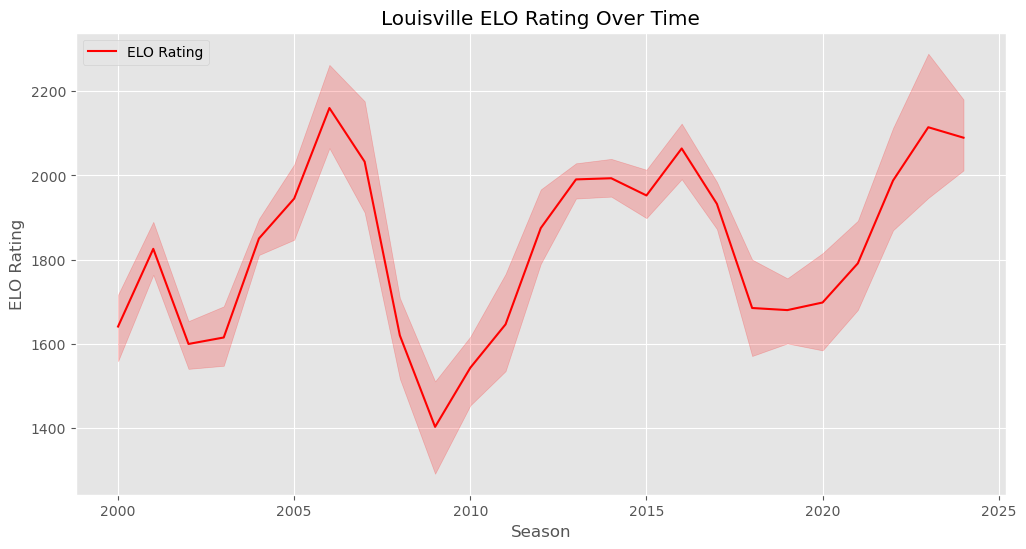

In [246]:
# can you create a plot of Wisconsin's ELO rating over time? plotying season on the x-axis and ELO rating on the y-axis
import matplotlib.pyplot as plt
import seaborn as sns

team = "Louisville"

df_wisconsin = df.query("home_team == @team | away_team == @team").copy()
df_wisconsin.loc[:, 'elo'] = df_wisconsin['home_elo'].where(df_wisconsin['home_team'] == team, df_wisconsin['away_elo'])
df_wisconsin.loc[:, 'elo_post'] = df_wisconsin['home_elo_post'].where(df_wisconsin['home_team'] == team, df_wisconsin['away_elo_post'])
plt.style.use('ggplot')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_wisconsin, x='season', y='elo_post', label='ELO Rating', color='red')
plt.title(f"{team} ELO Rating Over Time")
plt.xlabel("Season")
plt.ylabel("ELO Rating")
plt.legend()

plt.show()